In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub
import datetime

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
data_path = '../input/butterflies/final_data'
train_labels = pd.read_csv('../input/butterflies/final_data/train_labels.csv', dtype=str)
valid_labels = pd.read_csv('../input/butterflies/final_data/valid_labels.csv', dtype=str)

In [3]:
batch_size = 128
img_height = 224
img_width = 224

In [4]:
# Data augmentation pipeline
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
# Reading files from path in data frame
train_ds = train_datagen.flow_from_dataframe(train_labels, directory = data_path, x_col = 'filenames', y_col = 'label',target_size=(img_height, img_width), batch_size=batch_size, shuffle=True)
valid_ds = train_datagen.flow_from_dataframe(valid_labels, directory = data_path, x_col = 'filenames', y_col = 'label',target_size=(img_height, img_width),batch_size=batch_size, shuffle=True)

Found 4955 validated image filenames belonging to 50 classes.
Found 250 validated image filenames belonging to 50 classes.


In [5]:
test_dir = '../input/butterflies/final_data/test'
predict_ds = tf.keras.utils.image_dataset_from_directory(test_dir,seed=123,label_mode=None,image_size=(img_height, img_width),batch_size=batch_size, shuffle=False)

Found 250 files belonging to 1 classes.


2021-12-26 19:59:24.397222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 19:59:24.473459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 19:59:24.474297: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 19:59:24.477286: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

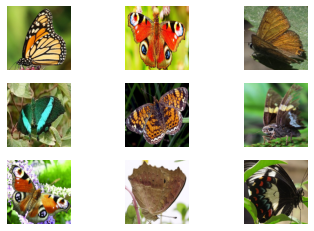

In [12]:
batch = train_ds[0]
images = batch[0]
labels = batch[1]

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
#     plt.title(labels[i])
    plt.axis("off")

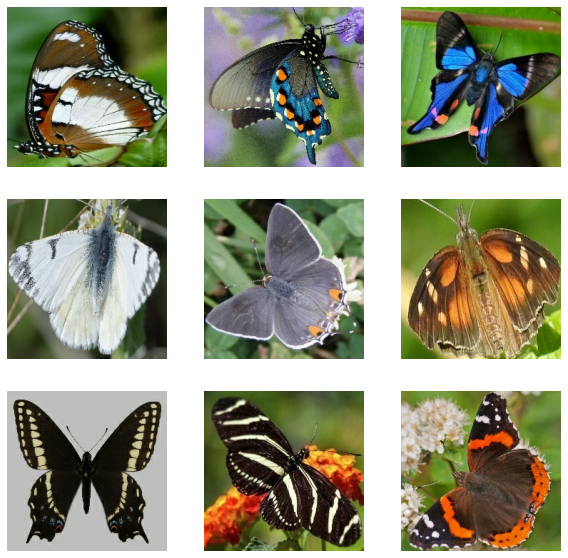

In [19]:
plt.figure(figsize=(10, 10))
for images in predict_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [20]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2

In [21]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [22]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

normalization_layer = tf.keras.layers.Rescaling(1./255)

In [23]:
num_classes = 50

model = tf.keras.Sequential([
  data_augmentation,
    normalization_layer,
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])
model.build((128,224,224,3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (128, 224, 224, 3)        0         
_________________________________________________________________
rescaling (Rescaling)        (128, 224, 224, 3)        0         
_________________________________________________________________
keras_layer (KerasLayer)     (128, 1280)               2257984   
_________________________________________________________________
dense (Dense)                (128, 50)                 64050     
Total params: 2,322,034
Trainable params: 64,050
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

2021-12-26 20:06:20.267153: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-26 20:06:20.267196: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-26 20:06:20.269355: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2021-12-26 20:06:20.478734: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-26 20:06:20.478932: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [25]:
NUM_EPOCHS = 40

history = model.fit(train_ds,
                    validation_data=valid_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/40


2021-12-26 20:06:27.297019: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/39 [..............................] - ETA: 6:08 - loss: 4.2380 - acc: 0.0234

2021-12-26 20:06:33.034753: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-26 20:06:33.035252: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/39 [>.............................] - ETA: 36s - loss: 4.0616 - acc: 0.0234 

2021-12-26 20:06:33.555040: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-26 20:06:33.564228: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-12-26 20:06:33.708332: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 375 callback api events and 372 activity events. 
2021-12-26 20:06:33.724414: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-26 20:06:33.749053: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fit/20211226-200620/train/plugins/profile/2021_12_26_20_06_33

2021-12-26 20:06:33.759651: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/fit/20211226-200620/train/plugins/profile/2021_12_26_20_06_33/d0adfd3fa0c0.trace.json.gz
2021-12-26 20:06:33.807411: I tensorflow/core/profiler/rpc/client/save_profile.cc:

39/39 [==============================] - 49s 1s/step - loss: 2.6330 - acc: 0.4044 - val_loss: 1.6459 - val_acc: 0.6840
Epoch 2/40
39/39 [==============================] - 15s 385ms/step - loss: 1.1355 - acc: 0.7948 - val_loss: 0.9939 - val_acc: 0.8040
Epoch 3/40
39/39 [==============================] - 15s 393ms/step - loss: 0.7398 - acc: 0.8616 - val_loss: 0.7258 - val_acc: 0.8760
Epoch 4/40
39/39 [==============================] - 14s 345ms/step - loss: 0.5764 - acc: 0.8910 - val_loss: 0.6048 - val_acc: 0.8720
Epoch 5/40
39/39 [==============================] - 15s 394ms/step - loss: 0.4778 - acc: 0.9053 - val_loss: 0.5200 - val_acc: 0.8960
Epoch 6/40
39/39 [==============================] - 15s 382ms/step - loss: 0.4152 - acc: 0.9162 - val_loss: 0.4479 - val_acc: 0.9120
Epoch 7/40
39/39 [==============================] - 15s 394ms/step - loss: 0.3708 - acc: 0.9217 - val_loss: 0.4006 - val_acc: 0.9080
Epoch 8/40
39/39 [==============================] - 15s 383ms/step - loss: 0.3255 -

In [26]:
preds_list = []
for item in predict_ds:
    preds = model.predict(item)
    preds_list.append(preds)

In [52]:
predicted_class_indices1=np.argmax(preds_list[0],axis=1)
predicted_class_indices2=np.argmax(preds_list[1],axis=1)
predicted_class_indices = np.concatenate((predicted_class_indices1, predicted_class_indices2))
labels = (train_ds.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [43]:
df = pd.DataFrame()
df["filename"] = "";
for item in range(0, 250):
    file_name = str(item)+'.jpg'
    df = df.append({'filename':file_name},ignore_index=True)
df = df.set_index('filename')
df["pred"] = ""

In [59]:
idx = 0
for item in predict_ds.file_paths:
    filen = item.split('/')[-1]
    df["pred"].loc[filen] = predictions[idx]
    idx = idx + 1

In [64]:
df.to_csv('submit_task12.csv', index=False)